# 0. Intro

- PyTorch의 Tensor를 이용하여 Image plot
- PyTorch를 이용하여 다양한 이미지 분류 모델을 생성
- 다양한 모델 학습 방법 사용
- 다양한 모델 평가 방법 사용
- 모델 성능 높이기

In [77]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [95]:
# import library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import albumentations as A

# kernel dead 방지
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# visualization
import matplotlib.pyplot as plt
import numpy as np

os.chdir('/content/gdrive/My Drive/Colab Notebooks')

# 1. Data

## 1.1  Data Read
PyTorch를 이용하여 CIFAR-10 데이터를 불러온다.

In [3]:
# torchvision 데이터 셋의 output은 [0,1]범위를 가지는 PILImage 이미지
# 이를 [-1,1] 범위로 정규화된 Tensor로 변환
# image 3 chanel, mean : [0.5, 0.5, 0.5], std : [0.5, 0.5, 0.5]
# output[channel] = (input[channel] - mean[channel]) / std[channel]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 10,
                                          shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 10,
                                          shuffle = True, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 1.2 Data Visualization

In [4]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

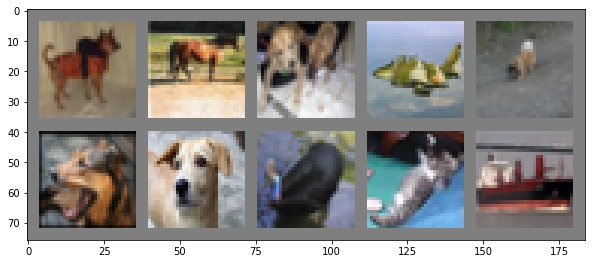

  dog horse   dog plane   dog   dog   dog  bird   cat  ship


In [5]:
# 학습용 랜덤 이미지 - original image
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow = 5, padding = 4, pad_value = 0))

print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [6]:
# torch로 시각화한 image 데이터 저장하기
torchvision.utils.save_image(images, fp = './train_random_img.jpg', nrow = 5, padding = 4)

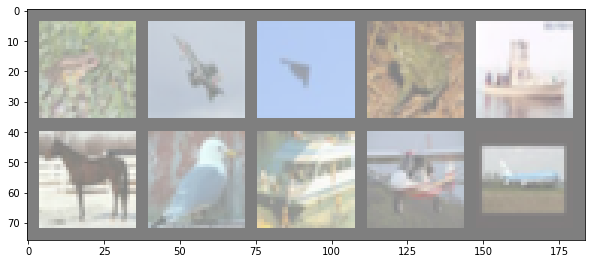

 frog plane plane  frog  ship horse  bird  ship plane plane


In [7]:
# 학습용 랜덤 이미지 - normalize image
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow = 5, padding = 4, pad_value = 0, normalize = True))

print(' '.join('%5s' % classes[labels[j]] for j in range(10)))

## 1.3 Data Augmentations
Albumentations 라이브러리를 사용하여 data augmentation 진행
- https://hoya012.github.io/blog/albumentation_tutorial/
- https://debuggercafe.com/image-augmentation-using-pytorch-and-albumentations/

# 2. Model Define

## 2.1 Basic CNN

In [8]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # 신경망 재료 구성하기
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # 실제 데이터와 엮기
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 2.2 Deep Basic CNN

In [9]:
class DeepBasicCNN(nn.Module):
    def __init__(self):
        super(DeepBasicCNN, self).__init__()
        # 신경망 재료 구성하기
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 640)
        self.fc2 = nn.Linear(640, 320)
        self.fc3 = nn.Linear(320, 160)
        self.fc4 = nn.Linear(160, 80)
        self.fc5 = nn.Linear(80, 40)
        self.fc6 = nn.Linear(40, 10)
        
    def forward(self, x):
        # 실제 데이터와 엮기
        x = F.relu(self.conv1(x)) # 30 by 30
        x = self.pool(F.relu(self.conv2(x))) # 14 by 14
        x = F.relu(self.conv3(x)) # 12 by 12
        x = self.pool(F.relu(self.conv4(x))) # 5 by 5
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

## 2.3 ResNet

- https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
- https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py (torch 구현)

In [123]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


# 3. Loss Function and Optimizer and Model Training

In [115]:
# GPU 사용 (colab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## 3.1 Basic CNN

In [116]:
net = BasicCNN().to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [117]:
for epoch in range(50):
    running_loss = 0.0
    
    # minibatch -> trainloader의 batch_size가 4로 설정
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 한번 mini-batch학습 수행할 때 마다 초기화
        # 4-data 1-train
        sgd_optimizer.zero_grad()
        
        outputs = net(inputs).to(device)
        loss = cross_entropy(outputs, labels).to(device)
        loss.backward()
        sgd_optimizer.step()
        
        # 통계정보 요약
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print('Finished Training')

[1,  2000] loss : 2.162
[1,  4000] loss : 1.749
[2,  2000] loss : 1.499
[2,  4000] loss : 1.418
[3,  2000] loss : 1.322
[3,  4000] loss : 1.264
[4,  2000] loss : 1.198
[4,  4000] loss : 1.180
[5,  2000] loss : 1.106
[5,  4000] loss : 1.092
[6,  2000] loss : 1.030
[6,  4000] loss : 1.030
[7,  2000] loss : 0.963
[7,  4000] loss : 0.972
[8,  2000] loss : 0.918
[8,  4000] loss : 0.919
[9,  2000] loss : 0.876
[9,  4000] loss : 0.890
[10,  2000] loss : 0.825
[10,  4000] loss : 0.845
[11,  2000] loss : 0.802
[11,  4000] loss : 0.808
[12,  2000] loss : 0.757
[12,  4000] loss : 0.776
[13,  2000] loss : 0.725
[13,  4000] loss : 0.745
[14,  2000] loss : 0.691
[14,  4000] loss : 0.725
[15,  2000] loss : 0.652
[15,  4000] loss : 0.700
[16,  2000] loss : 0.630
[16,  4000] loss : 0.684
[17,  2000] loss : 0.605
[17,  4000] loss : 0.644
[18,  2000] loss : 0.594
[18,  4000] loss : 0.621
[19,  2000] loss : 0.562
[19,  4000] loss : 0.599
[20,  2000] loss : 0.534
[20,  4000] loss : 0.591
[21,  2000] loss :

In [118]:
PATH = './cifar_BasicCNN.pth'
torch.save(net.state_dict(), PATH)

## 3.2 Deep Basic CNN

In [29]:
deep_net = DeepBasicCNN().to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(deep_net.parameters(), lr = 0.001, momentum = 0.9)

In [88]:
for epoch in range(50):
    running_loss = 0.0
    
    # minibatch -> trainloader의 batch_size가 4로 설정
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 한번 mini-batch학습 수행할 때 마다 초기화
        # 4-data 1-train
        sgd_optimizer.zero_grad()
        
        outputs = deep_net(inputs).to(device)
        loss = cross_entropy(outputs, labels).to(device)
        loss.backward()
        sgd_optimizer.step()
        
        # 통계정보 요약
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print('Finished Training')

[1,  2000] loss : 0.047
[1,  4000] loss : 0.067
[2,  2000] loss : 0.043
[2,  4000] loss : 0.067
[3,  2000] loss : 0.040
[3,  4000] loss : 0.057
[4,  2000] loss : 0.037
[4,  4000] loss : 0.048
[5,  2000] loss : 0.047
[5,  4000] loss : 0.040
[6,  2000] loss : 0.021
[6,  4000] loss : 0.046
[7,  2000] loss : 0.040
[7,  4000] loss : 0.041
[8,  2000] loss : 0.032
[8,  4000] loss : 0.034
[9,  2000] loss : 0.029
[9,  4000] loss : 0.031
[10,  2000] loss : 0.028
[10,  4000] loss : 0.027
[11,  2000] loss : 0.015
[11,  4000] loss : 0.025
[12,  2000] loss : 0.024
[12,  4000] loss : 0.032
[13,  2000] loss : 0.016
[13,  4000] loss : 0.025
[14,  2000] loss : 0.023
[14,  4000] loss : 0.025
[15,  2000] loss : 0.018
[15,  4000] loss : 0.018
[16,  2000] loss : 0.018
[16,  4000] loss : 0.022
[17,  2000] loss : 0.014
[17,  4000] loss : 0.025
[18,  2000] loss : 0.016
[18,  4000] loss : 0.020
[19,  2000] loss : 0.012
[19,  4000] loss : 0.030
[20,  2000] loss : 0.017
[20,  4000] loss : 0.011
[21,  2000] loss :

In [91]:
PATH = './cifar_DeepBasicCNN.pth'
torch.save(deep_net.state_dict(), PATH)

# net = Net()
# net.load_state_dict(torch.load(PATH))

## 3.3 ResNet

In [124]:
resnet = ResNet34().to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd_optimizer = optim.SGD(resnet.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
for epoch in range(50):
    running_loss = 0.0
    
    # minibatch -> trainloader의 batch_size가 4로 설정
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 한번 mini-batch학습 수행할 때 마다 초기화
        # 4-data 1-train
        sgd_optimizer.zero_grad()
        
        outputs = resnet(inputs).to(device)
        loss = cross_entropy(outputs, labels).to(device)
        loss.backward()
        sgd_optimizer.step()
        
        # 통계정보 요약
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print('Finished Training')

[1,  2000] loss : 1.688
[1,  4000] loss : 1.229
[2,  2000] loss : 0.868
[2,  4000] loss : 0.793
[3,  2000] loss : 0.608
[3,  4000] loss : 0.581
[4,  2000] loss : 0.444
[4,  4000] loss : 0.457
[5,  2000] loss : 0.315
[5,  4000] loss : 0.353
[6,  2000] loss : 0.234
[6,  4000] loss : 0.260
[7,  2000] loss : 0.167
[7,  4000] loss : 0.207
[8,  2000] loss : 0.118
[8,  4000] loss : 0.153
[9,  2000] loss : 0.100
[9,  4000] loss : 0.116
[10,  2000] loss : 0.073
[10,  4000] loss : 0.094
[11,  2000] loss : 0.058
[11,  4000] loss : 0.069
[12,  2000] loss : 0.045
[12,  4000] loss : 0.055
[13,  2000] loss : 0.032
[13,  4000] loss : 0.048
[14,  2000] loss : 0.032
[14,  4000] loss : 0.036
[15,  2000] loss : 0.025
[15,  4000] loss : 0.029
[16,  2000] loss : 0.023
[16,  4000] loss : 0.034
[17,  2000] loss : 0.022
[17,  4000] loss : 0.027
[18,  2000] loss : 0.021
[18,  4000] loss : 0.021
[19,  2000] loss : 0.012
[19,  4000] loss : 0.017
[20,  2000] loss : 0.015
[20,  4000] loss : 0.014
[21,  2000] loss :

In [ ]:
PATH = './cifar_ResNet34.pth'
torch.save(resnet.state_dict(), PATH)

# 4. Test Network

## 4.1 Basuc CNN Test Summary

In [119]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Basic CNN Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Basic CNN Accuracy of the network on the 10000 test images: 60 %


In [120]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Basic CNN Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Basic CNN Accuracy of plane : 58 %
Basic CNN Accuracy of   car : 73 %
Basic CNN Accuracy of  bird : 49 %
Basic CNN Accuracy of   cat : 37 %
Basic CNN Accuracy of  deer : 56 %
Basic CNN Accuracy of   dog : 59 %
Basic CNN Accuracy of  frog : 66 %
Basic CNN Accuracy of horse : 64 %
Basic CNN Accuracy of  ship : 79 %
Basic CNN Accuracy of truck : 69 %


## 4.2 Deep Basic CNN Test Summary

In [121]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Deep Basic CNN Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Deep Basic CNN Accuracy of the network on the 10000 test images: 72 %


In [122]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = deep_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Deep Basic CNN Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Deep Basic CNN Accuracy of plane : 72 %
Deep Basic CNN Accuracy of   car : 84 %
Deep Basic CNN Accuracy of  bird : 58 %
Deep Basic CNN Accuracy of   cat : 51 %
Deep Basic CNN Accuracy of  deer : 71 %
Deep Basic CNN Accuracy of   dog : 58 %
Deep Basic CNN Accuracy of  frog : 82 %
Deep Basic CNN Accuracy of horse : 74 %
Deep Basic CNN Accuracy of  ship : 85 %
Deep Basic CNN Accuracy of truck : 81 %


a